Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# DL05 Regression Model

### Lab Description

In this lab, we will learn how to build a basic regression model to predict house prices. You will understand how to use features to estimate a continuous target value and apply commonly used evaluation metrics such as MSE, MAE, and R².

In this hands-on lab, we will use the classic `California Housing Dataset`, which contains information about housing prices and features across California in 1990.

### What you can expect to learn

- Theoretical Understanding: Understand the fundamental concepts behind regression, including linear relationships, loss functions, and model assumptions.

- Data Preprocessing: Learn how to prepare data for regression tasks, including handling missing values and splitting datasets.

- Model Training & Evaluation: Gain hands-on experience training a linear regression model and evaluating it using metrics like MSE, MAE, and R².

- Result Interpretation: Visualize model predictions and assess how well the model captures real-world patterns in the data.

### Import necessary libraries

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### Required Dataset
This section loads the dataset and displays the data structure.
Before training, we perform basic data preprocessing:

- Split data into training and test sets

- Check for missing values

Note: If you meet HTTP Error when use fetch_california_housing(), try to download `cal_housing_py3.pkz` from internet and put it in your local storage. And then you can use fetch_california_housing(data_home="your folder path") to get the dataset.

In [ ]:
# Load California Housing dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="MedHouseVal")

# Display first few rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [38]:
# Check for missing values
print(X.isnull().sum())

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


In [4]:
# Don't include bias yet
X_features = X.copy()  # use all features
X_features = (X_features - X_features.mean()) / X_features.std()

# Add bias term (as first column)
X_features.insert(0, "bias", 1.0)

# Convert to numpy
X_np = X_features.values
y_np = y.values.reshape(-1, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

### Training

### Linear Regression via Closed-Form Solution

In this section, we will implement linear regression using the **closed-form solution**, also known as the **normal equation**. This method directly computes the optimal weights without iterative updates.

The formula is:

$$
\theta = (X^T X)^{-1} X^T y
$$

Where:
- $X$ is the input feature matrix (with the bias term included)
- $y$ is the target vector
- $\theta$ is the vector of learned coefficients (weights)

This approach is efficient for small-to-medium-sized datasets but can be computationally expensive or unstable if $ X^T X $ is non-invertible or ill-conditioned.

We will now compute the weights using this formula, make predictions on the test set, and evaluate the model using **Mean Squared Error (MSE)** and **R² score**.

In [5]:
# Closed-form solution
XTX_inv = np.linalg.inv(X_train.T @ X_train)
theta_normal = XTX_inv @ X_train.T @ y_train
y_pred_normal = X_test @ theta_normal

mse_normal = mean_squared_error(y_test, y_pred_normal)
r2_normal = r2_score(y_test, y_pred_normal)
print(f"[Normal Equation] MSE: {mse_normal:.2f}, R²: {r2_normal:.2f}")

[Normal Equation] MSE: 0.56, R²: 0.58


### Linear Regression via Gradient Descent

In this section, we will implement linear regression using **gradient descent**, an iterative optimization algorithm that minimizes the loss function by gradually adjusting the model weights.

The loss function we aim to minimize is the **Mean Squared Error (MSE)**:

$$
L(\theta) = \frac{1}{n} \sum_{i=1}^{n} (y_i - X_i \theta)^2
$$

The gradient of the loss with respect to the weights is:

$$
\nabla_\theta = -\frac{2}{n} X^T (y - X\theta)
$$

The weight update rule is:

$$
\theta := \theta - \alpha \cdot \nabla_\theta
$$

Where:  
- $X$ is the input feature matrix  
- $y$ is the target vector  
- $\theta$ is the weight vector  
- $\alpha$ is the learning rate  

To ensure numerical stability, we also apply **gradient clipping**, which limits the maximum gradient norm to prevent exploding updates.

We will train the model using this method, record the loss across iterations, and evaluate the final model on the test set using **MSE** and **R² score**.


In [6]:
def gradient_descent(X, y, lr=0.01, n_iters=1000, max_grad_norm=1.0):
    n_samples, n_features = X.shape
    theta = np.zeros((n_features, 1))
    loss_history = []

    for i in range(n_iters):
        y_pred = X @ theta
        error = y_pred - y
        gradients = (2 / n_samples) * (X.T @ error)

        # Gradient clipping
        grad_norm = np.linalg.norm(gradients)
        if grad_norm > max_grad_norm:
            gradients = gradients * (max_grad_norm / grad_norm)

        theta -= lr * gradients
        loss = np.mean(error**2)
        loss_history.append(loss)

    return theta, loss_history


theta_gd, loss_hist = gradient_descent(X_train, y_train, lr=0.01, n_iters=1000)
y_pred_gd = X_test @ theta_gd

mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)
print(f"[Gradient Descent] MSE: {mse_gd:.2f}, R²: {r2_gd:.2f}")

[Gradient Descent] MSE: 0.55, R²: 0.58


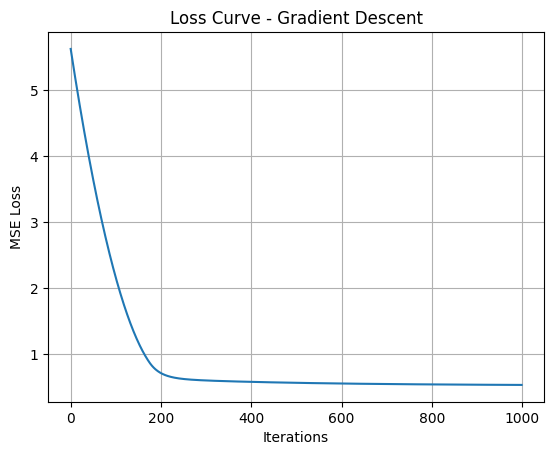

In [7]:
plt.plot(loss_hist)
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.title("Loss Curve - Gradient Descent")
plt.grid()
plt.show()

### Ridge Regression via Closed-Form Solution

In this section, we implement **Ridge Regression** using the **closed-form solution**. Ridge Regression extends ordinary least squares by adding an $L_2$ regularization term to penalize large weights and reduce overfitting.

The loss function becomes:

$$
L(\theta) = \frac{1}{n} \sum_{i=1}^{n} (y_i - X_i \theta)^2 + \lambda \|\theta\|_2^2
$$

The corresponding closed-form solution is:

$$
\theta = (X^T X + \lambda I)^{-1} X^T y
$$

Where:
- $X$ is the input feature matrix,
- $y$ is the target vector,
- $\theta$ is the weight vector,
- $I$ is the identity matrix,
- $\lambda$ is the regularization strength.

> Note: In our implementation, we exclude the bias term from regularization by setting the top-left entry of $I$ to zero.

We will use this formula to compute the weights, make predictions, and evaluate model performance using **MSE** and **R² score**.

In [8]:
def ridge_regression_closed_form(X, y, lambda_=1.0):
    n_features = X.shape[1]
    identity = np.eye(n_features)
    identity[0, 0] = 0  # Do not regularize the bias term
    theta_ridge = np.linalg.inv(X.T @ X + lambda_ * identity) @ X.T @ y
    return theta_ridge


theta_ridge = ridge_regression_closed_form(X_train, y_train, lambda_=10.0)
y_pred_ridge = X_test @ theta_ridge

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"[Ridge Regression] MSE: {mse_ridge:.2f}, R²: {r2_ridge:.2f}")

[Ridge Regression] MSE: 0.56, R²: 0.58


In [9]:
print("Model Comparison Summary:")
print(f"Normal Equation     -> MSE: {mse_normal:.2f}, R²: {r2_normal:.2f}")
print(f"Gradient Descent    -> MSE: {mse_gd:.2f}, R²: {r2_gd:.2f}")
print(f"Ridge Regression    -> MSE: {mse_ridge:.2f}, R²: {r2_ridge:.2f}")

Model Comparison Summary:
Normal Equation     -> MSE: 0.56, R²: 0.58
Gradient Descent    -> MSE: 0.55, R²: 0.58
Ridge Regression    -> MSE: 0.56, R²: 0.58
